In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from argparse import Namespace
from functools import partial

from data import UDDataModule
from transformers import AutoTokenizer, logging

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.set_verbosity_error()

In [5]:
args = Namespace(
    **{
        "treebank_name": "en_gum",
        "encoder_name": "roberta-base",
        "data_dir": "./data",
        "batch_size": 32,
        "num_workers": 4,
    }
)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name, add_prefix_space=True)
tokenize_fn = partial(
    tokenizer, is_split_into_words=True, return_tensors="pt", padding=True
)

In [65]:
ud_dep = UDDataModule(
    "DEP",
    args.treebank_name,
    tokenize_fn,
    args.data_dir,
    args.batch_size,
    args.num_workers,
)

In [66]:
ud_pos = UDDataModule(
    "POS",
    args.treebank_name,
    tokenize_fn,
    args.data_dir,
    args.batch_size,
    args.num_workers,
)

In [67]:
ud_dep.prepare_data()
ud_dep.setup()

ud_pos.prepare_data()
ud_pos.setup()

In [125]:
pos_ids = list(range(ud_pos.ud_train.info.features["upos"].feature.num_classes))

In [100]:
def count_classes(dataset, classes, task):
    counter_dict = {k: 0 for k in classes}
    for sentence in dataset[task]:
        for label in sentence:
            counter_dict[label] += 1
    return counter_dict

In [101]:
dep_test_counts = count_classes(ud_dep.ud_test, ud_dep.cname_to_id.keys(), "deprel")
dep_val_counts = count_classes(ud_dep.ud_val, ud_dep.cname_to_id.keys(), "deprel")
dep_train_counts = count_classes(ud_dep.ud_train, ud_dep.cname_to_id.keys(), "deprel")

In [126]:
pos_test_counts = count_classes(ud_pos.ud_test, pos_ids, "upos")
pos_val_counts = count_classes(ud_pos.ud_val, pos_ids, "upos")
pos_train_counts = count_classes(ud_pos.ud_train, pos_ids, "upos")

In [137]:
pos_train_counts.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [128]:
import matplotlib.pyplot as plt

/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_57175/2392947014.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(dep_train_counts.keys(), rotation=60, ha="right")
/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_57175/2392947014.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(


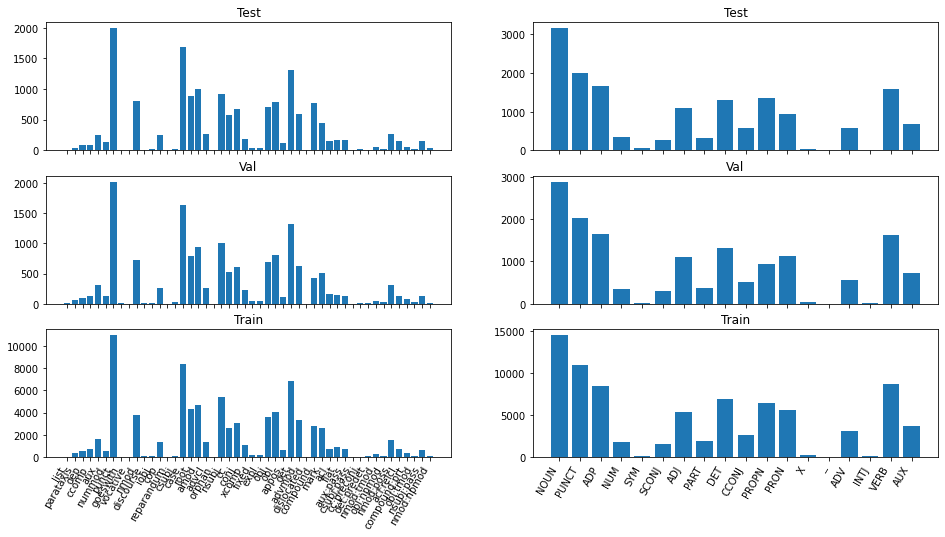

In [140]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(16, 8), sharex="col"
)

ax1.bar(dep_test_counts.keys(), dep_test_counts.values())
ax1.set_title("Test")
ax3.bar(dep_val_counts.keys(), dep_val_counts.values())
ax3.set_title("Val")
ax5.bar(dep_train_counts.keys(), dep_train_counts.values())
ax5.set_title("Train")
ax5.set_xticklabels(dep_train_counts.keys(), rotation=60, ha="right")

ax2.bar(
    [ud_pos.id_to_cname[k] for k in pos_test_counts.keys()], pos_test_counts.values()
)
ax2.set_title("Test")
ax4.bar([ud_pos.id_to_cname[k] for k in pos_val_counts.keys()], pos_val_counts.values())
ax4.set_title("Val")
ax6.bar(
    [ud_pos.id_to_cname[k] for k in pos_train_counts.keys()], pos_train_counts.values()
)
ax6.set_title("Train")
ax6.set_xticklabels(
    [ud_pos.id_to_cname[k] for k in pos_train_counts.keys()], rotation=60, ha="right"
)

plt.show()